In [1]:
include("src/qsrfe.jl")
using .qsrfe

In [2]:
using DataFrames, MLJ, MLJLinearModels
using LinearAlgebra

In [3]:

bX, bY = @load_boston
bX = Matrix(DataFrame(bX))
bY = collect(bY)
bX

bX = (bX .- mean(bX)) ./ std(bX)
Y = (bY .- mean(bY)) ./ std(bY)
(xtrain, xtest), (ytrain, ytest) = partition((bX, bY), 0.8, rng=123, multi=true)

(([-0.5038479125622459 -0.3736555203370192 … 2.078229709420622 -0.467825129690138; -0.501959374129676 -0.5073242348197996 … 1.4241218550991361 -0.42919487120461447; … ; -0.5071204568645706 -0.13973526999215344 … 2.0856483230744165 -0.4765135961315187; -0.45784081189620396 -0.5073242348197996 … 1.595551981423302 -0.3308815317025295], [-0.507019470150779 -0.5073242348197996 … 2.117929317622008 -0.4170310181866815; -0.438932637054685 -0.5073242348197996 … 2.0303763096357867 -0.38682188871357304; … ; -0.20158311583976354 -0.5073242348197996 … 0.08262263654995178 -0.2601707817411386; -0.5037144443508349 -0.3736555203370192 … 2.117929317622008 -0.4432300862253064]), ([48.8, 20.2, 20.9, 13.4, 12.7, 13.6, 22.1, 24.4, 13.3, 20.3  …  36.2, 20.7, 42.3, 5.0, 18.7, 19.6, 17.9, 41.7, 31.2, 17.2], [23.3, 14.6, 32.0, 22.6, 14.1, 19.1, 20.3, 12.6, 50.0, 24.8  …  22.2, 19.8, 31.7, 27.1, 19.5, 24.6, 15.6, 26.4, 7.0, 33.8]))

In [3]:
using LIBSVM

In [5]:
svm = svmtrain(xtrain',ytrain;svmtype=EpsilonSVR,epsilon=1.5,cost=76000.,tolerance=0.1,kernel = Kernel.RadialBasis,verbose=true)
ypred, decval1 = svmpredict(svm, xtest')
ypredtrain, decval2 = svmpredict(svm,xtrain')

test_metrics(ytest,ypred,ytrain,ypredtrain)



.....................................*...............................................................................*.........*
optimization finished, #iter = 100828
nu = 0.481239
obj = -41780654.884246, rho = -252.975752
nSV = 229, nBSV = 170
MSE: 8.602512598610483 train MSE: 14.446826788102786
rel: 0.09209163343264073 train rel: 0.10769089507670612


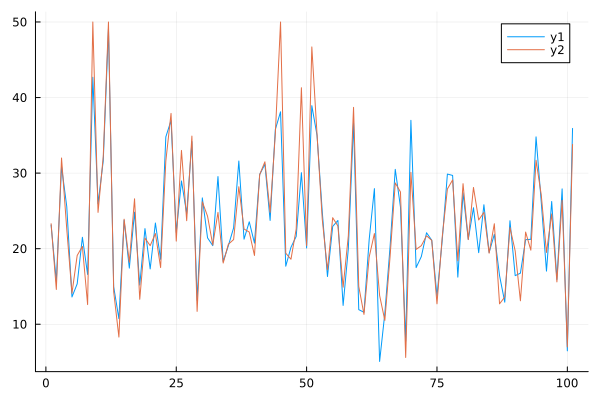

In [6]:

using Plots
plot(ypred)
plot!(ytest)

In [7]:
function rbf(x,y,gamma)
    return exp(-gamma * norm(x-y)^2)
end

rbf (generic function with 1 method)

In [8]:
function K(X, xtest; gamma=1.0 / size(X, 1))
    M = zeros(size(X,2),size(xtest,2))
    for i in 1:size(X,2), j in 1:size(xtest,2)
        M[i,j] = rbf(X[:,i],xtest[:,j], gamma)
    end
    return M'
end

K (generic function with 1 method)

In [9]:
function predictK(M,coeffs, rho)
    return vec(M * coeffs)  .- rho
end

predictK (generic function with 1 method)

In [10]:
yahh = predictK(K(svm.SVs.X,xtest'),svm.coefs,svm.rho)

101-element Vector{Float64}:
 23.12508212061033
 15.65844355711846
 30.873781287742474
 25.575716632642013
 13.606490897471247
 15.343076687326118
 21.505658781379623
 16.58633978937536
 42.68648508961445
 25.942471424792473
  ⋮
 21.24047436263021
 34.797243497907345
 26.146928570398757
 17.02669485724431
 26.242134683887286
 15.92639213191245
 27.909941413838112
  6.4775240346115766
 35.91335656132827

In [11]:
N = 1000
ω, ζ = gen_weights(N,size(xtrain,2));

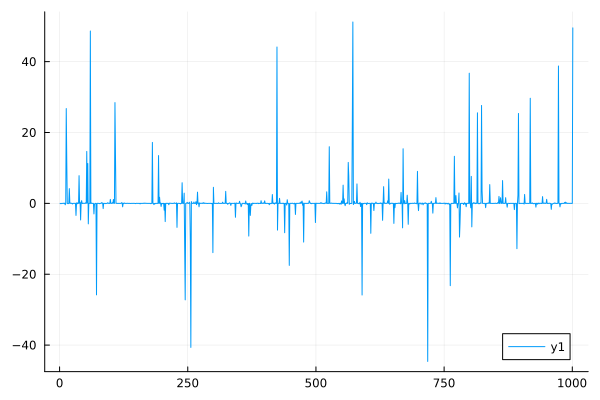

In [12]:

A = compute_featuremap(xtrain,ω,rff,ζ)
T = compute_featuremap(xtest,ω,rff,ζ)
lasso = LassoRegression(0.002; fit_intercept=true) #if intercept is true, the last element of c is the intercept
solver = FISTA(max_iter=20000)
c = MLJLinearModels.fit(lasso,A,ytrain;solver)
plot(c)


In [13]:
ypred_srfe = hcat(T,ones(size(T,1))) * c
ytrain_srfe = hcat(A,ones(size(A,1))) * c

test_metrics(ytest,ypred_srfe,ytrain,ytrain_srfe)

MSE: 8.008561867387565 train MSE: 7.9278435432632355
rel: 0.10204782103619076 train rel: 0.10084621060247934


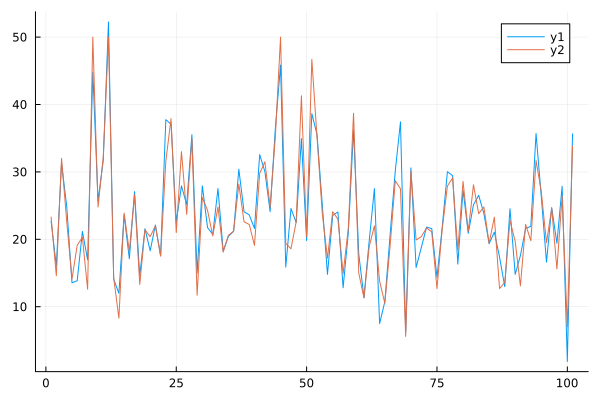

In [14]:
plot(ypred_srfe)
plot!(ytest)

In [15]:
kern = A * A'
tkern = A * T'
svm_pre = svmtrain(kern,ytrain;svmtype=EpsilonSVR,epsilon=0.1,cost=10.,tolerance=0.1,kernel = Kernel.Precomputed,verbose=true)
ypred, _ = svmpredict(svm_pre, tkern)
yptrain, _ = svmpredict(svm_pre,kern)

test_metrics(ytest,ypred,ytrain,yptrain)


......................*...............*
optimization finished, #iter = 30744
nu = 0.840622
obj = -9290.007178, rho = -31.602758
nSV = 394, nBSV = 298
MSE: 10.513840101984634 train MSE: 14.458714621493922
rel: 0.09761302086029942 train rel: 0.09131765459807628


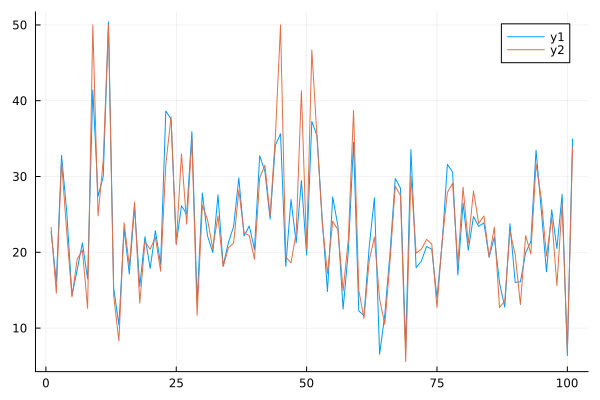

In [16]:
plot(ypred)
plot!(ytest)

In [17]:
beta = A[svm_pre.SVs.indices,:]' * svm_pre.coefs

1000×1 Matrix{Float64}:
 -0.27294414240111564
 -1.5050368825184037
 -1.0110720786459062
 -1.304889251905891
  0.9877802264649134
 -0.7845541483298462
  0.30068273582838856
  1.4197974682692474
 -0.1467669498268691
 -1.260111941671462
  ⋮
 -2.3847201551161277
  0.9955631790237902
  0.4874386815161529
 -1.4497675780000279
 -0.5647227636544478
 -0.0031142058451898436
  0.024355120239498262
 -0.23168940629426515
 -1.3144241761926514

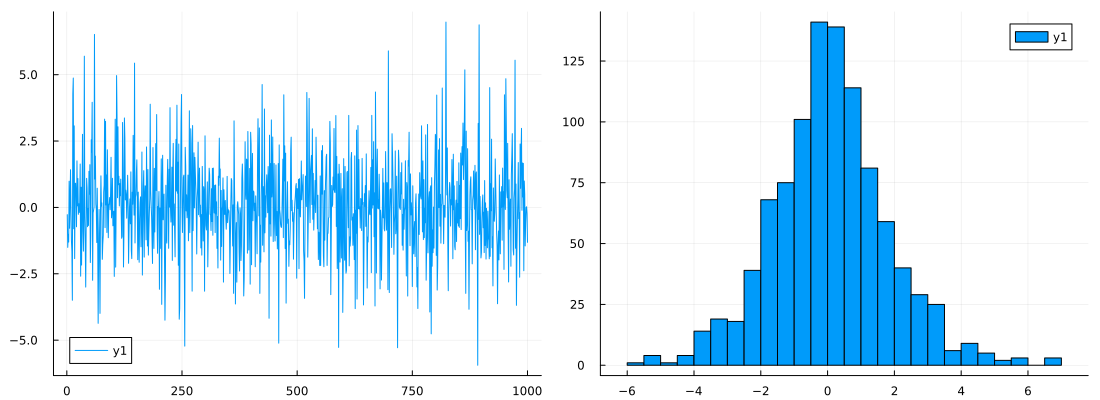

In [18]:
p1 = plot(beta)
p2 = histogram(beta)
plot(p1, p2, layout=(1,2),size=(1100,400))

In [19]:
ypred = (beta' * T')' .- svm_pre.rho
ytraintest = (beta' * A')' .- svm_pre.rho

test_metrics(ytest,ypred,ytrain,ytraintest)

MSE: 10.513840101967531 train MSE: 14.458714621502095
rel: 0.09761302086029179 train rel: 0.09131765459812112


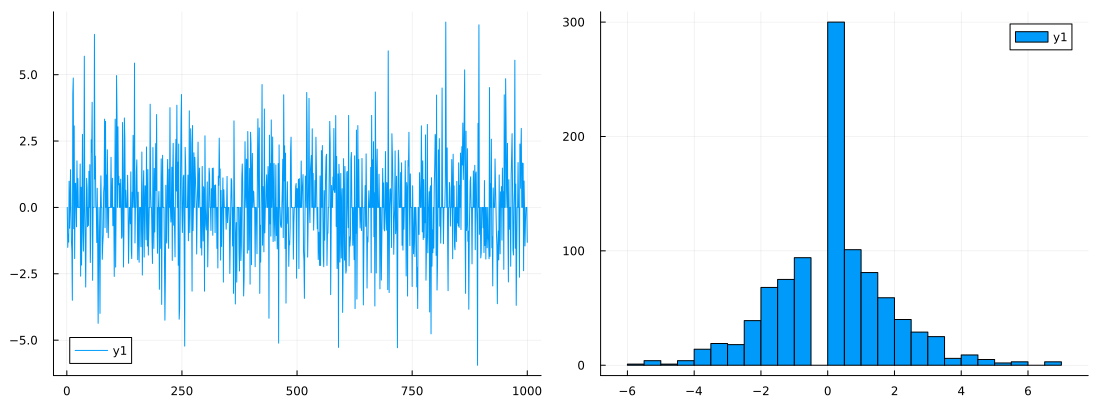

In [20]:
beta2 = prune(vec(beta),0.7);
p1 = plot(beta2)
p2 = histogram(beta2)
plot(p1, p2, layout=(1,2),size=(1100,400))

In [21]:
ypred = (beta2' * T')' .- svm_pre.rho
ytraintest = (beta2' * A')' .- svm_pre.rho

test_metrics(ytest,ypred,ytrain,ytraintest)

MSE: 59.05911122661864 train MSE: 65.16241322439936
rel: 0.28391669189496127 train rel: 0.31357189391494866


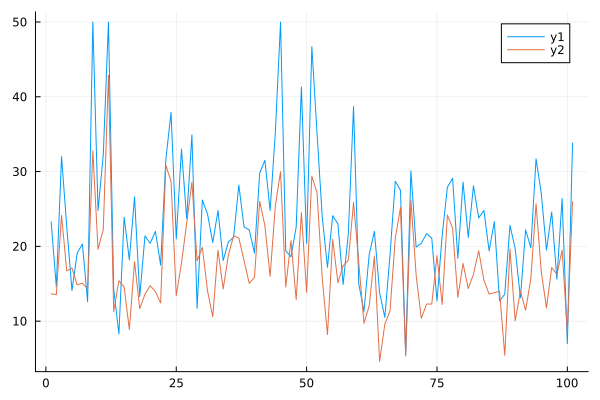

In [22]:
plot(ytest)
plot!(ypred)